### Clasiffication of Pneumonia vs Normal with ChestX-ray (cell 2018)-DenseNet121
DataSet: https://data.mendeley.com/datasets/rscbjbr9sj/2

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = "/home/nbuser/chest_xray/"
sz=224
bs = 32

In [4]:
os.listdir(PATH)

['test',
 'valid',
 'Dense121-ROC.ipynb',
 'models',
 'Vgg16-ROC.ipynb',
 '.ipynb_checkpoints',
 'train',
 'keras-vgg16.ipynb',
 'tmp',
 'ResNet34-ROC.ipynb']

In [5]:
os.listdir(f'{PATH}valid')

['PNEUMONIA', 'NORMAL']

In [6]:
files = os.listdir(f'{PATH}valid/NORMAL')[:5]
files

['NORMAL2-IM-0300-0001.jpeg',
 'NORMAL2-IM-0102-0001.jpeg',
 'NORMAL2-IM-0201-0001.jpeg',
 'NORMAL2-IM-0120-0001.jpeg',
 'NORMAL2-IM-0199-0001.jpeg']

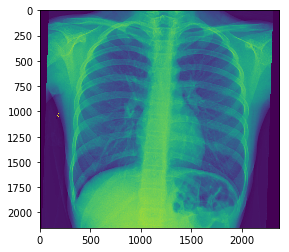

In [7]:
img = plt.imread(f'{PATH}valid/NORMAL/{files[1]}')
plt.imshow(img);

In [8]:
os.makedirs('/cache/tmp', exist_ok=True)
!ln -fs /cache/tmp {PATH}

In [9]:
arch = dn121
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


epoch      trn_loss   val_loss   accuracy                  
    0      0.183616   0.506226   0.80609   
    1      0.110836   0.506297   0.842949                  



[array([0.5063]), 0.8429487194770422]

In [10]:
data.classes

['NORMAL', 'PNEUMONIA']

In [11]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [12]:
lrf=learn.lr_find()

 82%|████████▏ | 67/82 [00:01<00:00, 40.40it/s, loss=3.04] 


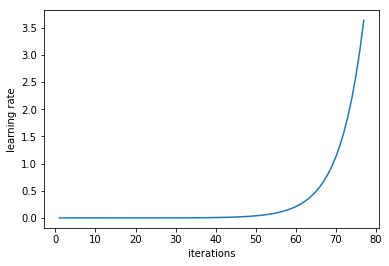

In [13]:
learn.sched.plot_lr()

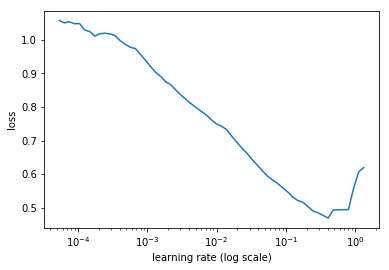

In [14]:
learn.sched.plot()

### Data Augmentation

In [15]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [16]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [17]:
ims = np.stack([get_augs() for i in range(6)])

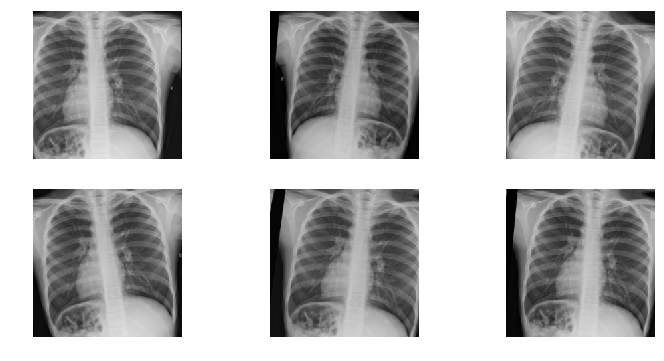

In [18]:
plots(ims, rows=2)

In [19]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [20]:
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.184217   0.488681   0.820513  



[array([0.48868]), 0.8205128220411447]

In [21]:
learn.precompute=False

In [22]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.133317   0.44137    0.854167  
    1      0.13376    0.504464   0.842949                  
    2      0.120721   0.456222   0.860577                  



[array([0.45622]), 0.8605769246052473]

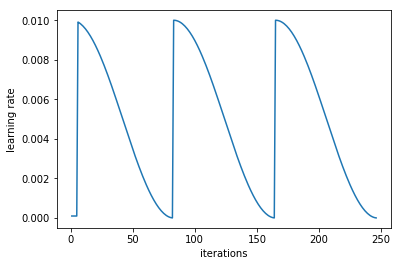

In [23]:
learn.sched.plot_lr()

In [24]:
learn.unfreeze()

In [25]:
lr=np.array([1e-4,1e-3,1e-2])

In [26]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.143572   0.34631    0.876603  
    1      0.117188   0.323963   0.897436                  
    2      0.092198   0.366867   0.883013                   
    3      0.089982   0.342836   0.899038                   
    4      0.072672   0.359531   0.895833                   
    5      0.067225   0.347695   0.902244                   
    6      0.060599   0.337207   0.905449                   



[array([0.33721]), 0.9054487194770422]

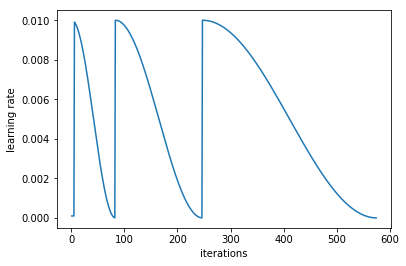

In [27]:
learn.sched.plot_lr()

In [28]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [29]:
accuracy_np(probs, y)

0.8766025641025641

In [30]:
probs[-10:]

array([[0.00118, 0.99882],
       [0.00375, 0.99625],
       [0.00473, 0.99527],
       [0.00078, 0.99922],
       [0.0006 , 0.9994 ],
       [0.00293, 0.99707],
       [0.00209, 0.99791],
       [0.99173, 0.00827],
       [0.00409, 0.99591],
       [0.00511, 0.99489]], dtype=float32)

### Confusion Matrix

In [31]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [32]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[159  75]
 [  2 388]]


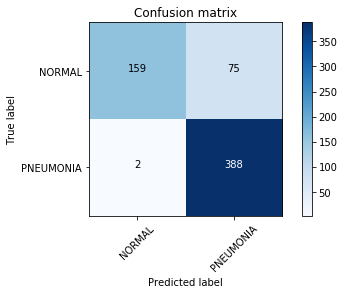

In [33]:
plot_confusion_matrix(cm, data.classes)

### ROC Curve

In [34]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y, probs)

In [35]:
from sklearn.metrics import auc
auc = auc(fpr, tpr)
print(auc)

0.9731536269997809


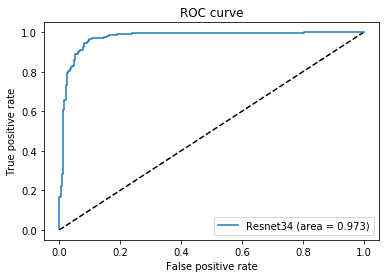

In [36]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Resnet34 (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [37]:
print(fpr)

[0.      0.      0.00427 0.00427 0.00855 0.00855 0.01282 0.01282 0.01282 0.01282 0.01709 0.01709 0.02137
 0.02137 0.02564 0.02564 0.02991 0.02991 0.03419 0.03419 0.03846 0.03846 0.04274 0.04274 0.04701 0.04701
 0.05128 0.05128 0.05556 0.05556 0.05983 0.05983 0.0641  0.0641  0.06838 0.06838 0.07692 0.07692 0.0812
 0.0812  0.08547 0.08547 0.08974 0.08974 0.09402 0.09402 0.09829 0.09829 0.10684 0.10684 0.1453  0.1453
 0.15385 0.15385 0.15812 0.15812 0.16239 0.16239 0.16667 0.16667 0.18803 0.18803 0.23077 0.23077 0.23932
 0.23932 0.32906 0.32906 0.80342 0.80342 1.     ]


In [38]:
print(tpr)

[0.00256 0.16667 0.16667 0.22308 0.22308 0.28462 0.28462 0.57179 0.57692 0.60513 0.60513 0.65641 0.65641
 0.73077 0.73077 0.79231 0.79231 0.80513 0.80513 0.81538 0.81538 0.82564 0.82564 0.83077 0.83077 0.85897
 0.85897 0.88974 0.88974 0.89231 0.89231 0.9     0.9     0.90513 0.90513 0.90769 0.90769 0.92564 0.92564
 0.94359 0.94359 0.94615 0.94615 0.95128 0.95128 0.95641 0.95641 0.96667 0.96667 0.97179 0.97179 0.97436
 0.97436 0.97692 0.97692 0.98205 0.98205 0.98462 0.98462 0.98718 0.98718 0.98974 0.98974 0.99231 0.99231
 0.99487 0.99487 0.99744 0.99744 1.      1.     ]


In [39]:
probs[:5]

array([0.17806, 0.29686, 0.97813, 0.25984, 0.98314], dtype=float32)

### Performance Matrix

In [40]:
predict1 = []
for i in range(len(probs)):
    if probs[i] > 0.5:
        predict1.append(1)
    else:
        predict1.append(0)

In [41]:
len(predict1)

624

In [42]:
y_pred = np.array(predict1)

In [43]:
print(sklearn.metrics.classification_report(y_pred, y))

             precision    recall  f1-score   support

          0       0.68      0.99      0.81       161
          1       0.99      0.84      0.91       463

avg / total       0.91      0.88      0.88       624

